# WARNING DO NOT COMMIT DIRECTLY TO MAIN GET ON YOUR OWN BRANCH FIRST 🙏🏼🙌🏼

# Setting up the GPU for use!

In [1]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cuda
random seed: 1234


## First import frame without confidental columns!

In [8]:
education_data = pd.read_csv('students_clean.csv')
education_data

,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,Female,22,Mathematics,97.36,40.61,59.61,73.69,53.17,73.4,62.84,59.8865,F,10.3,Yes,No,Master's,Medium,1,5.9
1,Male,18,Business,97.71,57.27,74.00,74.23,98.23,88.0,98.23,81.9170,B,27.1,No,No,High School,Low,4,4.3
2,Male,24,Engineering,99.52,41.84,63.85,85.85,50.00,4.7,91.22,67.7170,D,12.4,Yes,No,High School,Low,9,6.1
3,Female,24,Engineering,90.38,45.65,44.44,68.10,66.27,4.2,55.48,51.6535,F,25.5,No,Yes,High School,Low,8,4.9
4,Female,23,CS,59.41,53.13,61.77,67.66,83.98,64.3,87.43,71.4030,C,13.3,Yes,No,Master's,Medium,6,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Male,19,CS,96.09,45.86,45.63,74.13,81.53,9.8,51.66,53.5470,F,7.8,No,No,Master's,Medium,10,4.5
4996,Male,19,Mathematics,96.30,78.67,47.42,57.89,85.96,47.8,52.33,59.0240,F,24.2,No,Yes,NaN,Medium,4,7.2
4997,Female,24,CS,89.94,50.84,65.83,84.69,82.27,7.5,97.89,74.7560,C,7.6,No,Yes,NaN,High,5,6.6
4998,Male,23,Engineering,99.09,55.44,57.45,78.78,55.96,62.9,84.74,68.6585,D,14.5,Yes,No,PhD,Medium,10,5.9


## Encoding Parent Education with KNN

So the first thing that I need to think about here is how do I define a similar student in my similarity algorithm. My initial thought is that the best indicators for similar circumstances are going to be the "Family_Income_Level", "Internet_Access_at_Home", and then maybe the same gender and a similar age. We'll start there and see where that gits us.

In [28]:
education_data_copy = education_data.copy()

In [45]:
# Now define the algorithm with these similarity measure.

def get_knn_parent_educat(ind,k,educ_df,display_dist_frame):
    
    educ_df_dist_frame = educ_df.copy()
    educ_df_dist_frame['Gender'] = np.where(educ_df_dist_frame['Gender']=='Male',1,0)
    educ_df_dist_frame['Internet_Access_at_Home'] = \
        np.where(educ_df_dist_frame['Internet_Access_at_Home']=='No',1,0)
    map_fam_inc_dict = {'Low':1,'Medium':2,'High':3}
    educ_df_dist_frame['Family_Income_Level'] = educ_df_dist_frame['Family_Income_Level'].map(map_fam_inc_dict)


    
    # So first I will define a margin for the numerical age column, I also need to decide if I want
    # to look higher or lower, I feel like higher ages probably would be less similar to somebody of 
    # a lower age so I will define the margin as being able to be slightly below.
    age_below_margin = 3

    # Now get all the information for the person that we want to impute the value in this column of.
    #display(educ_df_dist_frame.iloc[ind])
    this_age = educ_df_dist_frame.at[ind,"Age"]
    this_gender = educ_df_dist_frame.at[ind,"Gender"]
    this_intas = educ_df_dist_frame.at[ind,"Internet_Access_at_Home"]
    this_faminc_lev = educ_df_dist_frame.at[ind,"Family_Income_Level"]

    # Drop the row corresponding to the one we are trying to impute from the distance.
    educ_df_dist_frame = educ_df_dist_frame.drop(ind)[["Age","Gender", \
                                                                "Internet_Access_at_Home","Family_Income_Level","Parent_Education_Level"]]
    
    educ_df_dist_frame = educ_df_dist_frame[~educ_df_dist_frame['Parent_Education_Level'].isna()]
    


    educ_df_dist_frame['Age'] = educ_df_dist_frame['Age'].apply(lambda x: this_age-x) # 0 for same age positve for younger
    educ_df_dist_frame['Gender'] = educ_df_dist_frame['Gender'].apply(lambda x: np.abs(this_gender-x)) # 0 for same 1 for not.
    educ_df_dist_frame['Internet_Access_at_Home'] = \
                            educ_df_dist_frame['Internet_Access_at_Home'].apply(lambda x: np.abs(this_intas-x)) # 0 for the same 1 for not.
    educ_df_dist_frame['Family_Income_Level'] = educ_df_dist_frame['Family_Income_Level'].apply(lambda x: this_faminc_lev-x) # 0 if same, positive if lower, negative if higher.

    # Now create a similarity report!! This will definently need to be fine tuned, for the age and family
    # income and and age I will need to fintune if lower or higher makes the similarity score more positive.
    # Right now I feel that we want people that are lower in both catagories to be more similar as for example:
    # I would think a middle class person would share a lot more similarities with a lower class person then
    # a higher class person. Simarly for age I would think someone that is slightly younger would share more
    # take for example a younger person that is also in college for a person that is in college vs a older
    # person that is out of college. I think the persom still in college should be the most similar.
    def compute_similarity_score(row):
        return(row['Age']+row['Gender']+row['Internet_Access_at_Home']+row['Family_Income_Level'])
    

    # Now apply this formula to each row in the frame.
    educ_df_dist_frame['sim_score'] = educ_df_dist_frame.apply(compute_similarity_score,axis=1)
    
    # Now sort in descending order based upon the similarity score.
    educ_df_dist_frame = educ_df_dist_frame.sort_values(by='sim_score',ascending=False).reset_index(drop=True)

    # Now pick the k nearest neighbors. I will do three cases here. Since I did a score there is guarnteed to
    # to be k or more neighbors I believe.
    top_k_res = educ_df_dist_frame.iloc[:k]

    if display_dist_frame:
        display(top_k_res)

    return(top_k_res[['Parent_Education_Level']].mode().at[0,'Parent_Education_Level'])

In [46]:
# Testing on one row

i = 4997

display(education_data_copy.iloc[i])
print("\n\n")

get_knn_parent_educat(i,5,education_data_copy,True)

Gender                        Female
Age                               24
Department                        CS
Attendance (%)                 89.94
Midterm_Score                  50.84
Final_Score                    65.83
Assignments_Avg                84.69
Quizzes_Avg                    82.27
Participation_Score              7.5
Projects_Score                 97.89
Total_Score                   74.756
Grade                              C
Study_Hours_per_Week             7.6
Extracurricular_Activities        No
Internet_Access_at_Home          Yes
Parent_Education_Level           NaN
Family_Income_Level             High
Stress_Level (1-10)                5
Sleep_Hours_per_Night            6.6
Name: 4997, dtype: object

,Age,Gender,Internet_Access_at_Home,Family_Income_Level,Parent_Education_Level,sim_score
0,6,1,1,2,Bachelor's,10
1,6,1,1,2,High School,10
2,6,1,1,2,High School,10
3,6,1,1,2,Master's,10
4,6,1,1,2,PhD,10


'High School'

## To evaluate how my algorithm is doing I am going to do the following. I am going to take all entries that already have a value in this catagory, loop through each entry, and for each entry I will pretend as though it were NA and get a accuracy count essentially of how many times my algorithm guess the correct education level.

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

The best k value was 20 with a accuracy of 26.8


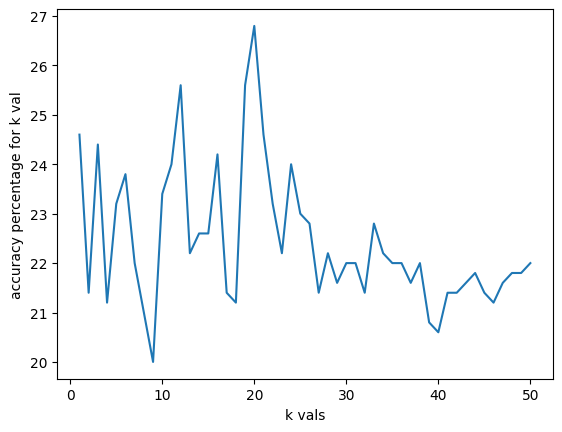

In [51]:
# First intialize counters, get a replicate frame that has no na's.
educ_data_no_na = education_data[~education_data['Parent_Education_Level'].isna()].copy()

# Also record the best k value. For now I am just gonna start with k between 1 and say 50.

best_k = 0
best_acc = 0

min_k = 1
max_k = 50

num_no_na = educ_data_no_na.shape[0]

num_correct_curr = 0

k_val_accs = []

base_seed = 122
batch_size = 500

for k in tqdm(range(min_k,max_k+1)):
    num_correct_curr = 0

    no_na_sample = educ_data_no_na.sample(n=batch_size,random_state=(base_seed+1)).reset_index(drop=True)
    
    for ind,row in tqdm(no_na_sample.iterrows(),total=batch_size,leave=False):
        # first just cause this was taking way to long intially I am going to just test
        # each k on a subset of the original frame.
        
        # First remeber what the true value for this row is.
        gold_parent_educ = no_na_sample.at[ind,'Parent_Education_Level']

        # Set current parent education to NA to use KNN to predict it.
        educ_data_no_na.loc[ind,'Parent_Education_Level'] = np.nan

        # Now run KNN alg.
        pred_parent_educ = get_knn_parent_educat(ind,k,no_na_sample,False)

        # Now immedietly put back the old non na value.
        no_na_sample.loc[ind,'Parent_Education_Level'] = gold_parent_educ

        # Now check if the prediction was correct.
        if(gold_parent_educ==pred_parent_educ):
            num_correct_curr += 1

    # Now calculate accuracy percentage for the current k value.
    curr_acc = (num_correct_curr/batch_size)*100
    # Append this round's accuracy to the current list of accuracy vals.
    k_val_accs.append(curr_acc)

    # Now check if the current k is the most accurate.
    if curr_acc >= best_acc:
        best_k = k
        best_acc = curr_acc

# Now make a quick little plot to show how the accuracy changed wit the different k values
import matplotlib.pyplot as plt

print(f"The best k value was {best_k} with a accuracy of {best_acc}")

k_vals = np.arange(min_k,(max_k+1))
plt.plot(k_vals,k_val_accs)
plt.xlabel("k vals")
plt.ylabel("accuracy percentage for k val")
plt.show()

## With the original performance of my algorithm being an abismal 26 percent accuracy, which is basically as good as just guessing or worse, I am going to look at the correlation between the family education column and all the other features and see if I am in fact using the strongest indicators of similarity.

In [34]:
# First I am going to need to just do a quick and dirty conversion of all non-numeric columns to numeric
# ones.

educ_all_numeric = education_data.copy()

# I'm just doing this because I don't want to get false correlations because of NA's.
educ_all_numeric = educ_all_numeric.dropna()

for col in ['Gender','Department','Grade','Extracurricular_Activities', 'Internet_Access_at_Home',
       'Parent_Education_Level', 'Family_Income_Level']:
    educ_all_numeric[col] = educ_all_numeric[col].astype("category").cat.codes

educ_all_numeric.head()

cols = np.array(educ_all_numeric.columns).tolist()
cols.remove('Parent_Education_Level')

corr_levels = {}
corr_levs_non_abs = {}

# Ok so now everything is numeric and I can compare its correlation with the 'Parent_Educational_Level'
for col in cols:
    corr_curr = educ_all_numeric[col].corr(educ_all_numeric['Parent_Education_Level'])

    corr_levs_non_abs[col] = corr_curr
    
    corr_levels[col] = np.abs(corr_curr)


print(f"The row correlation scores are as follows: \n{corr_levs_non_abs}\n\n\n")

sorted_cors = sorted(corr_levels.items(),key=lambda x: x[1], reverse=True)
for corr in sorted_cors:
    print(corr)

The row correlation scores are as follows: 
{'Gender': 0.003161367162065458, 'Age': -0.030079252414818777, 'Department': 0.019155267742812492, 'Attendance (%)': 0.005528682840108309, 'Midterm_Score': 0.015417298539233905, 'Final_Score': -0.026805298603143454, 'Assignments_Avg': 0.004910222443516004, 'Quizzes_Avg': -0.028926301448270218, 'Participation_Score': 0.031040099490232106, 'Projects_Score': -0.012720015414707252, 'Total_Score': -0.0159663817992082, 'Grade': 0.016701602921356546, 'Study_Hours_per_Week': -0.007788685985384251, 'Extracurricular_Activities': 0.0007389791207303169, 'Internet_Access_at_Home': -0.029102137342631864, 'Family_Income_Level': 0.004590666482291438, 'Stress_Level (1-10)': -0.009716429781570668, 'Sleep_Hours_per_Night': -0.013861237581648526}



('Participation_Score', 0.031040099490232106)
('Age', 0.030079252414818777)
('Internet_Access_at_Home', 0.029102137342631864)
('Quizzes_Avg', 0.028926301448270218)
('Final_Score', 0.026805298603143454)
('Department',

## Encoding Gender & Extra cericulars & Internet at home!

In [6]:
education_data['Gender'] = education_data['Gender'].replace({'Male': 1, 'Female': 0}).astype(int)
education_data['Internet_Access_at_Home'] = education_data['Internet_Access_at_Home'].replace({'Yes': 1, 'No': 0}).astype(int)
education_data['Extracurricular_Activities'] = education_data['Extracurricular_Activities'].replace({'Yes': 1, 'No': 0}).astype(int)
education_data.head()

,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,0,22,Mathematics,97.36,40.61,59.61,73.69,53.17,73.4,62.84,59.8865,F,10.3,1,0,Master's,Medium,1,5.9
1,1,18,Business,97.71,57.27,74.00,74.23,98.23,88.0,98.23,81.9170,B,27.1,0,0,High School,Low,4,4.3
2,1,24,Engineering,99.52,41.84,63.85,85.85,50.00,4.7,91.22,67.7170,D,12.4,1,0,High School,Low,9,6.1
3,0,24,Engineering,90.38,45.65,44.44,68.10,66.27,4.2,55.48,51.6535,F,25.5,0,1,High School,Low,8,4.9
4,0,23,CS,59.41,53.13,61.77,67.66,83.98,64.3,87.43,71.4030,C,13.3,1,0,Master's,Medium,6,4.5


## Encoding Family Income!

## Encoding Department Info!

In [9]:
labels = open('departments.txt').read().splitlines()
department_mapping = {name: index for index, name in enumerate(labels)}
department_indices = education_data['Department'].map(department_mapping)
education_data.insert(3, 'department index', department_indices)
education_data

,Gender,Age,Department,department index,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,Female,22,Mathematics,0,97.36,40.61,59.61,73.69,53.17,73.4,62.84,59.8865,F,10.3,Yes,No,Master's,Medium,1,5.9
1,Male,18,Business,1,97.71,57.27,74.00,74.23,98.23,88.0,98.23,81.9170,B,27.1,No,No,High School,Low,4,4.3
2,Male,24,Engineering,2,99.52,41.84,63.85,85.85,50.00,4.7,91.22,67.7170,D,12.4,Yes,No,High School,Low,9,6.1
3,Female,24,Engineering,2,90.38,45.65,44.44,68.10,66.27,4.2,55.48,51.6535,F,25.5,No,Yes,High School,Low,8,4.9
4,Female,23,CS,3,59.41,53.13,61.77,67.66,83.98,64.3,87.43,71.4030,C,13.3,Yes,No,Master's,Medium,6,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Male,19,CS,3,96.09,45.86,45.63,74.13,81.53,9.8,51.66,53.5470,F,7.8,No,No,Master's,Medium,10,4.5
4996,Male,19,Mathematics,0,96.30,78.67,47.42,57.89,85.96,47.8,52.33,59.0240,F,24.2,No,Yes,NaN,Medium,4,7.2
4997,Female,24,CS,3,89.94,50.84,65.83,84.69,82.27,7.5,97.89,74.7560,C,7.6,No,Yes,NaN,High,5,6.6
4998,Male,23,Engineering,2,99.09,55.44,57.45,78.78,55.96,62.9,84.74,68.6585,D,14.5,Yes,No,PhD,Medium,10,5.9
